In [1]:
import tensorflow as tf
import keras
#from tensorflow.keras.datasets import mnist
#from tensorflow.keras import Input
#from tensorflow.keras.layers import Dense, Activation, Conv1D, Flatten, Dropout, MaxPooling1D, BatchNormalization
from tensorflow.keras.models import Model
#from keras.models import Sequential
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

See also README.txt.

In [3]:
model_path = "curriculum_cnn2_GData10000_5epochs_level0/"
model_name = "cnn2"

levels = [0] # just one should be chosen
nrows = 20000
test_size = 0.2 # this should be consistent with how the data was created, test_size = |test set| / |all data|
nrows_test = int(test_size * nrows)

for level in levels: # len(levels) should be just one, changing levels so far works only manually
    
    # load the model and the labels of the test set
    cnn = keras.models.load_model(model_path + model_name)
    y_and_ids_test = np.load(model_path + "y_and_ids_test_{}.npy".format(level))
    y_test = y_and_ids_test[:, 0]
    ids_test = y_and_ids_test[:, 1]
    
    # reconstruct the name of the appropriate .csv file
    csv_names = []
    #csv_default = "00000000_0.csv"
    for idx in range(nrows_test):
        is_event = y_test[idx]
        ID = int(ids_test[idx] + level*1e4)
        #if not(idx%100):
        #   print(ID)
        ten_thousands = ID // 10000
        ID = (ID - 10000*ten_thousands)
        thousands = ID // 1000
        ID = (ID - 1000*thousands)
        hundreds = ID // 100
        ID = (ID - 100*hundreds)
        dozens =  ID // 10
        ID = ID - 10*dozens
        ones = ID
        csv_name = "000{}{}{}{}{}_{}.csv".format(ten_thousands, thousands, hundreds, dozens, ones, is_event)
        csv_names.append(csv_name)
    
    # extract the desired data from .csv files
    csv_path = "FT_data/FreqCL_csv_{}/".format(level)
    PISNRs = np.zeros(nrows_test)
    for idx in range(nrows_test):
        df = pd.read_csv(csv_path+csv_names[idx])
        PISNRs[idx] = df["netPIsnr"]
    
    # save the extracted data
    np.save(csv_path+"PISNRs_{}".format(level), PISNRs)

In [8]:
# example of a csv file
#pd.read_csv("older_versions/gw_data_sequential_first100/FreqCL_O3_1/00010000_0.csv")

,Unnamed: 0,netSnr,netPIsnr,H1_PISNR,L1_PISNR,V1_PISNR,d,m1,m2,ra,...,pycbc_H1_PISNR,pycbc_L1_PISNR,pycbc_V1_PISNR,injection,max_noisy_H1,max_noisyL1,max_noisyV1,max_hH1,max_hL1,max_hV1
0,0,47.357591,14.831984,10.547,8.518728,6.014967,21.936246,2.517517,2.257709,3.104776,...,11.274427,9.121622,6.454807,0,43.154543,47.256989,46.913262,0.0,1.207923e-13,3.552714e-14


In [5]:
#pd.read_csv("older_versions/gw_data_sequential_first100/FreqCL_O3_1/00010000_1.csv")

,Unnamed: 0,netSnr,netPIsnr,H1_PISNR,L1_PISNR,V1_PISNR,d,m1,m2,ra,...,pycbc_H1_PISNR,pycbc_L1_PISNR,pycbc_V1_PISNR,injection,max_noisy_H1,max_noisyL1,max_noisyV1,max_hH1,max_hL1,max_hV1
0,0,47.357591,14.831984,10.547,8.518728,6.014967,21.936246,2.517517,2.257709,3.104776,...,11.274427,9.121622,6.454807,1,46.673747,39.763302,43.898728,3.457422,2.563699,2.156663


In [4]:
# use the model to predict probabilities of GWs being in the test set
import time 

for level in levels:
    
    # load the data
    PISRNs = np.load(csv_path+"PISNRs_{}.npy".format(level))
    #plt.hist(PISRNs, bins=40)
    #plt.show()
    
    # reconstruct the data in the test set
    X = np.load("FT_data/X_FT_GData_{}.npy".format(level))
    # rows of X that end up in the test set are identified below, the transformation comes from the fact that
    # first nrows/2 is 0s (noise) and second nrows/2 is 1s (noise+GWs), this of course gets shuffled by
    # train_test_split, but event IDs and 0/1 status is preserved in y_and_ids_test, allowing us to reconstruct X_test
    rows_test = ids_test + y_test * nrows // 2
    X_test = X[rows_test,:,:]
    # exchange second and third dimension to comply with keras expected array shape ("channels last")
    X_test = np.swapaxes(X_test, 1, 2)
    
    # predict the labels
    t1 = time.time()
    y_pred = cnn.predict(X_test)
    t2 = time.time()
    print(t2-t1)
    np.save(model_path + "y_pred_{}".format(level), y_pred)

53.42396640777588


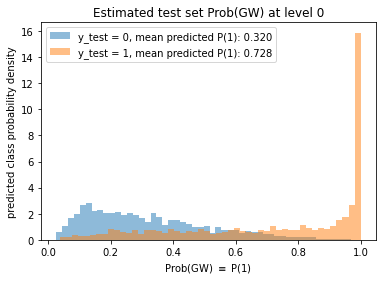

In [5]:
# plot the predicted probabilites
for level in levels:
    y_pred = np.load(model_path + "y_pred_{}.npy".format(level)).flatten()
    y_pred_0 = y_pred[np.argwhere(y_test==0)]
    y_pred_1 = y_pred[np.argwhere(y_test==1)]
    plt.hist(y_pred_0, alpha=0.5, bins=50, density=True, label="y_test = 0, mean predicted P(1): {:.3f}".format(np.mean(y_pred_0)))
    plt.hist(y_pred_1, alpha=0.5, bins=50, density=True, label="y_test = 1, mean predicted P(1): {:.3f}".format(np.mean(y_pred_1)))
    plt.legend()
    plt.title("Estimated test set Prob(GW) at level {}".format(level))
    plt.xlabel("Prob(GW) $\equiv$ P(1)")
    plt.ylabel("predicted class probability density")
    plt.savefig(model_path + "fig_pred_prob_{}".format(level), dpi=400)
    plt.show()

In [6]:
# FINDING THE PROBABILITY THRESHOLD FOR DETECTION, UNDER A FIXED FAP

desired_FAP = 0.01 # desired maximum false alarm probability

from sklearn.metrics import confusion_matrix

for level in levels:
    
    # find detection threshold for FAP <= desired_FAP
    # conf_mat = confusion_matrix(y_test, y_pred > 0.5)
    # print("threshold = 0.5:\n", conf_mat)
    thresholds = np.arange(0, 1, 0.001) # different thresholds for model probability of GW (P(1)) to conclude detection
    FAPs = np.zeros_like(thresholds) # false alarm probabilities
    TAPs = np.zeros_like(thresholds) # true alarm probabilities
    accuracies = np.zeros_like(thresholds) # accuracies
    for idx, threshold in enumerate(thresholds):
        conf_mat = confusion_matrix(y_test, y_pred > threshold)
        FP = conf_mat[0, 1]
        TN = conf_mat[0, 0]
        FN = conf_mat[1, 0]
        TP = conf_mat[1, 1]
        TAPs[idx] = TP / (TP + FN) # out of all GW events, TAP * 100% will raise alarm 
        FAPs[idx] = FP / (TN + FP) # out of all non-GW "events", only FAP * 100% will raise alarm 
        accuracies[idx] = (TP + TN) / (TP + TN + FP + FN)
    idx_opt = np.argmin( np.abs(FAPs - desired_FAP))
    threshold_opt = thresholds[idx_opt]
    accuracy_opt = accuracies[idx_opt]
    accuracy_05 = accuracies[len(accuracies)//2]
    TAP_opt = TAPs[idx_opt]
    TAP_05 = TAPs[len(accuracies)//2]
    print("Optimal threshold for FAP = {:.2f} is P(y=1) = {:.3f}".format(desired_FAP, threshold_opt))
    print("This threshold of P(y=1) produces accuracy of {:.3f}, as opposed to {:.3f} if threshold was chosen as 0.5,\nand a TAP of {:.3f}, as opposed to {:.3f} if threshold was chosen as 0.5."
          .format(accuracy_opt, accuracy_05, TAP_opt, TAP_05))
    print("(sanity check: corresponding FAP is {:.3f})".format(FAPs[idx_opt]))

Optimal threshold for FAP = 0.01 is P(y=1) = 0.830
This threshold of P(y=1) produces accuracy of 0.748, as opposed to 0.779 if threshold was chosen as 0.5,
and a TAP of 0.502, as opposed to 0.745 if threshold was chosen as 0.5.
(sanity check: corresponding FAP is 0.010)


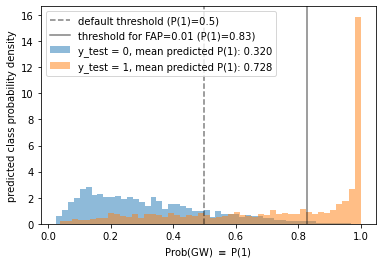

In [7]:
for level in levels:
    plt.hist(y_pred_0, alpha=0.5, bins=50, density=True, label="y_test = 0, mean predicted P(1): {:.3f}".format(np.mean(y_pred_0)))
    plt.hist(y_pred_1, alpha=0.5, bins=50, density=True, label="y_test = 1, mean predicted P(1): {:.3f}".format(np.mean(y_pred_1)))
    plt.axvline(x = 0.5, alpha=0.5, c="k", linestyle="dashed", label="default threshold (P(1)=0.5)")
    plt.axvline(x = threshold_opt, alpha=0.5, c="k", label="threshold for FAP={} (P(1)={:.2f})".format(desired_FAP, threshold_opt))
    plt.legend()
    #plt.title("Estimated test set Prob(GW) at level {}".format(level))
    plt.xlabel("Prob(GW) $\equiv$ P(1)")
    plt.ylabel("predicted class probability density")
    plt.savefig(model_path + "fig_pred_prob_withBothLines_{}".format(level), dpi=400)
    plt.show()


quantiles 0,0.1...,0.9 of PISRN distribution: [ 4.24 14.53 18.64 22.17 25.47 29.24 34.05 39.92 47.38 60.94]

bins of PISRNs are in range(10): [6 9 7 ... 9 8 2]

counts in these 10 bins: [400, 400, 400, 400, 400, 400, 399, 401, 400, 400]


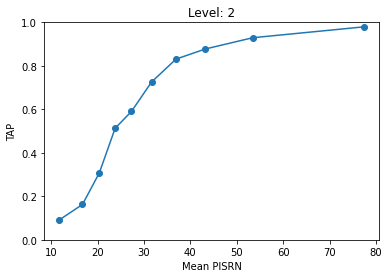

In [46]:
# Plot the equivalent of figure 5 from the 2022 Paper (CNN for GW early alert: going down in freq.)

for level in levels:
        
    # calculate the 10-percentage quantiles
    quants10 = np.quantile(PISRNs, np.arange(0, 1, 0.1), interpolation="linear")
    
    # assign values to the bins calculated with those quantiles (by default, to the left)
    bins10 = np.digitize(PISRNs, quants10, right=False)-1 # from 0 to 9 inclusive
    bins10_counts = [np.sum(bins10==i) for i in range(10)]
    print("\nquantiles 0,0.1...,0.9 of PISRN distribution: {}".format(np.round(quants10,2)))
    print("\nbins of PISRNs are in range(10):", bins10)
    print("\ncounts in these 10 bins:", bins10_counts)
    
    # calculate the bin TAPs and PISNR bin averages
    TAPs_bin = np.zeros(10)
    PISNRs_bin = np.zeros(10)
    for idx_bin in range(10):
        # PISNR
        PISNRs_bin[idx_bin] = np.mean( PISNRs[np.argwhere(bins10==idx_bin)] )
        # TAP
        y_test_bin = y_test[np.argwhere(bins10==idx_bin)]
        y_pred_bin = y_pred[np.argwhere(bins10==idx_bin)]
        conf_mat = confusion_matrix(y_test_bin, y_pred_bin > threshold_opt)
        FN = conf_mat[1, 0]
        TP = conf_mat[1, 1]
        TAPs_bin[idx_bin] = TP / (TP + FN) # out of all GW events, (TAP*100)% will raise alarm 
    
    np.save(model_path + "PISNR_TAP_{}".format(level), np.stack((PISNRs_bin, TAPs_bin)))
    
    plt.title("Level: {}".format(level))
    plt.scatter(PISNRs_bin, TAPs_bin)
    plt.plot(PISNRs_bin, TAPs_bin)
    plt.xlabel("Mean PISRN")
    plt.ylabel("TAP")
    plt.ylim(0, 1)
    plt.savefig(model_path + "PISNR_TAP_{}.png".format(level))
    plt.show()

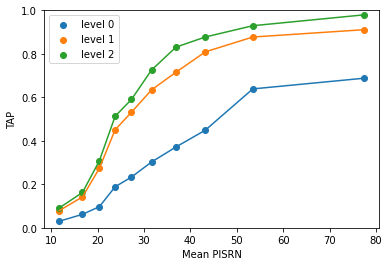

In [47]:
# do the plot of all levels together

path_to_load_data = model_path
path_to_save_png = model_path

for level in [0, 1, 2]:#,1,2]:
    PISNRs_TAPs = np.load(path_to_load_data + "PISNR_TAP_{}.npy".format(level))
    TAPs_bin = PISNRs_TAPs[1, :]
    #plt.title("Level: {}".format(level))
    plt.scatter(PISNRs_bin, TAPs_bin, label="level {}".format(level))
    plt.plot(PISNRs_bin, TAPs_bin)
    plt.xlabel("Mean PISRN")
    plt.ylabel("TAP")
    plt.ylim(0, 1)
    plt.legend()
plt.savefig(path_to_save_png+"PISNR_TAP_{}.png".format(level))
plt.show()

In [52]:
np.shape(np.argwhere(bins10==0))

(400, 1)

In [16]:
len(PISRNs) #- len(np.unique(PISRNs))

4000

In [34]:
len(np.arange(0,1,0.1))

10

In [24]:
np.digitize([0.5, 1, 1.5, 2, 2.5, 3, 3, 3, 3.5], bins=[1,2, 3, 4])

array([0, 1, 1, 2, 2, 3, 3, 3, 3], dtype=int64)

In [38]:
np.arange(10)[[1,2,3]]

array([1, 2, 3])

In [65]:
b = np.array([[1,2,3,4,5,0], [10,20,30,40,50,60]])
np.nonzero(b)

(array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1], dtype=int64),
 array([0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 5], dtype=int64))

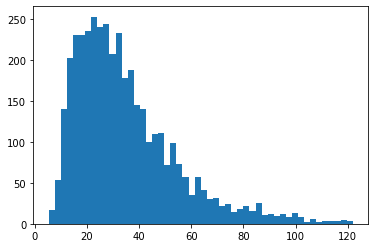

In [98]:
plt.hist(PISRNs, bins=50)
plt.show()

In [100]:
a = np.array([1,2,3,4])
b = np.array([5,6,7,8])
#c = np.array([9,10,11,12])

Z = np.stack((a, b))
Z[0, :]

array([1, 2, 3, 4])